In [2]:
import cv2 as cv
import cv2.aruco as aruco
import numpy as np
import matplotlib.pyplot as plt

960 1280


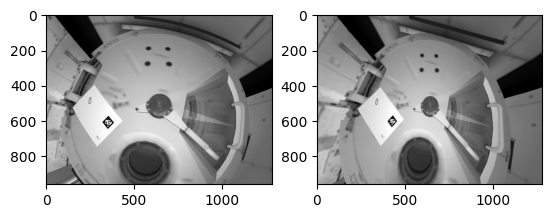

In [3]:


def distort_image():
    
    

    dist=np.array([ -0.164787, 0.020375, -0.001572, -0.000369, 0.000000 ])
    mtx=np.array([ [523.105750, 0.000000, 635.434258],[0.000000, 534.765913, 500.335102],[0.000000, 0.000000, 1.000000] ])
    
    img = cv.imread('Area_1_test.png')
    h, w = img.shape[:2]
    print(h,w)
    
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
    # undistort
    mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
    
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    cv.imwrite('distort.png', dst)
    plt.subplot(122)
    plt.imshow(dst)
    plt.subplot(121)
    plt.imshow(img)
    plt.show()


distort_image()

Image shape:  (960, 1280, 3)


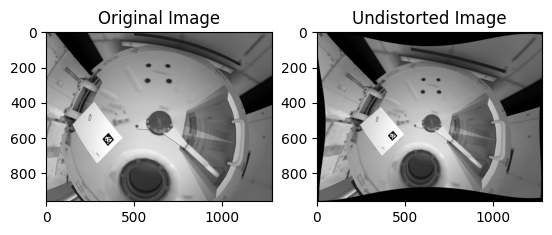

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-u4kjpz2z\opencv\modules\imgcodecs\src\loadsave.cpp:732: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [20]:

import os

camera_matrix = np.array(
    [
        [661.783002, 0.000000, 595.212041],
        [0.000000, 671.508662, 489.094196],
        [0.000000, 0.000000, 1.000000],
    ]
)
dist_coeffs = np.array([-0.215168, 0.044354, 0.003615, 0.005093, 0.000000])


def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    print("Image shape: ", image.shape)
    new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(
        camera_matrix, dist_coeffs, (w, h), 1, (w, h)
    )
    undistorted_image = cv.undistort(
        image, camera_matrix, dist_coeffs, None, new_camera_matrix
    )
    return undistorted_image


dir = os.getcwd()
#images = [f for f in os.listdir(dir) if f.endswith(".png")]
images='Area_1_test.png'
undistort_images = []
'''
for image in images:
    img = cv.imread(image)
    undistort_images.append(undistort_image(img, camera_matrix, dist_coeffs))
'''
img = cv.imread(images)
undistort_images.append(undistort_image(img, camera_matrix, dist_coeffs))

for i in range(len(images)):
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(undistort_images[i])
    plt.title("Undistorted Image")
    plt.show()
    cv.imwrite("undistorted_" + images[i], undistort_images[i])

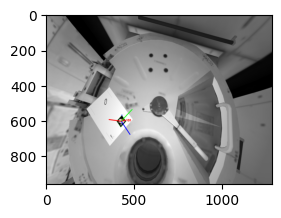

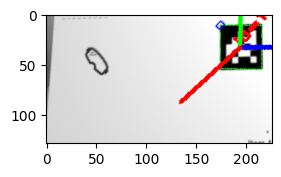

In [56]:
def find_aruco_and_cut():
    img = cv.imread('distort.png')
    #img = cv.imread('aruco_test.png') #6X6
    aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)
    parameters = aruco.DetectorParameters_create()
    corners, ids, rejected = aruco.detectMarkers(img, aruco_dict, parameters=parameters)
    aruco.drawDetectedMarkers(img, corners, ids)
    
    '''
    cv.imshow('img', img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    '''

    dist=np.array([ -0.164787, 0.020375, -0.001572, -0.000369, 0.000000 ])
    mtx=np.array([ [523.105750, 0.000000, 635.434258],[0.000000, 534.765913, 500.335102],[0.000000, 0.000000, 1.000000] ])
    
    rvec=np.array([])
    tvec=np.array([])
    rvec,tvec,_=aruco.estimatePoseSingleMarkers(corners,0.05, mtx, dist, rvec, tvec)
    
    for i in range(rvec.shape[0]):
        aruco.drawAxis(img, mtx, dist, rvec[i,:,:], tvec[i,:,:], 0.1)
    plt.subplot(121)
    plt.imshow(img)
    plt.show()
    #print(rvec)

    index=0
    center_x = np.mean(corners[index][0][:, 0])
    center_y = np.mean(corners[index][0][:, 1])


    w=1280
    h=960
    


    #四邊座標
    #假設corners[0][0]為左上角，並以順時針方向旋轉
    #print(rvec,"\n",tvec,"\n",center_x,"\n",center_y)
    #print(corners[0][0])
    print()
    hoz=corners[0][0][0]-corners[0][0][1] #left
    vert=corners[0][0][0]-corners[0][0][3] #up

    #left top
    lt=corners[0][0][0]+(20.75/5)*hoz+(1.25/5)*vert

    #right top
    rt=corners[0][0][0]+(-6.25/5)*hoz+(1.25/5)*vert
    #left bottom
    lb=corners[0][0][0]+(20.75/5)*hoz+(-13.75/5)*vert
    #right bottom
    rb=corners[0][0][0]+(-6.25/5)*hoz+(-13.75/5)*vert

    rt_dst=lt+np.array([np.linalg.norm(lt-rt),0])
    rb_dst=rt_dst+np.array([0,np.linalg.norm(rt-rb)])

    lb_dst=lt+np.array([0,np.linalg.norm(lt-lb)])

    #透視
    src_points=np.array([lt,rt,lb,rb],dtype="float32")
    dst_points=np.array([[0,0],rt_dst-lt,lb_dst-lt,rb_dst-lt],dtype="float32")
    #print(lt,"\n",rt,"\n",lb,"\n",rb,"\n",rb_dst,"\n",lb_dst,"\n")
    M=cv.getPerspectiveTransform(src_points,dst_points)
    perspective=cv.warpPerspective(img,M,(int(np.linalg.norm(lt-rt)),int(np.linalg.norm(rt-rb))),cv.INTER_LINEAR)
    #cropped_image = cv.warpPerspective(image, perspective_transform_matrix, (w, h))

    
    cv.imshow('Cropped Image', perspective)
    plt.subplot(122)
    plt.imshow(perspective)
    plt.show()
    
    cv.destroyAllWindows()
    
    
find_aruco_and_cut()